In [32]:
import pandas as pd
import numpy as np

import requests

import os
import time
from datetime import datetime
import sys
import yaml
import gc


from data_loader import *
from utils import *
from nn import *
from models import *
from llm import *
from llm_hf import *
import folder_manager

import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#1e1e1e',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.grid': True,
    'grid.color': 'gray'
})

pd.set_option("display.max_column",None)
print(os.getcwd())


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

pd.options.display.max_rows = 100


def auto_reload():
    %load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("config.yaml",'r') as f:
    config = yaml.safe_load(f)

home_dir = config['HOME_DIRECTORY']
home_dir

'/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG'

In [3]:
create_submodel("llm_new")

# API Football:
https://www.api-football.com

![PYTHON LOGO](https://www.api-football.com/public/img/news/archi-beta.jpg)

In [4]:
leagues_dat = get_leagues(home_dir +"/data/Leagues/leagues.parquet")
leagues_dat[['league_id','league_name','country_name']]

,league_id,league_name,country_name
0,4,Euro Championship,World
1,21,Confederations Cup,World
2,61,Ligue 1,France
3,144,Jupiler Pro League,Belgium
4,71,Serie A,Brazil
...,...,...,...
1128,1131,Super Cup,Mongolia
1129,1132,AFC Challenge League,World
1130,1133,Goiano - 3,Brazil
1131,1001,CONCACAF Women U20,World


# Leagues subset:

In [5]:
# Configs
major_leagues = ["Premier League","La Liga","Serie A","Bundesliga","Eredivisie","Ligue 1"]
major_countries = ["England","Spain","Italy","Germany","Netherlands","France","Brazil"]
teams = ["Liverpool","Wolves"] # teams to pull players data of
seasons = [2022,2021,2023,2024] # seasons to pull players and teams stats of



leagues_subset = leagues_dat[leagues_dat.league_name.isin(major_leagues) & leagues_dat.country_name.isin(major_countries)] # league ID to pull from, current values: {39:premier league}, Add to dictionary as needed

In [6]:
leagues_subset

,seasons,league_id,league_name,league_type,league_logo,country_name,country_code,country_flag
2,"[{'coverage': {'fixtures': {'events': True, 'l...",61,Ligue 1,League,https://media.api-sports.io/football/leagues/6...,France,FR,https://media.api-sports.io/flags/fr.svg
4,"[{'coverage': {'fixtures': {'events': True, 'l...",71,Serie A,League,https://media.api-sports.io/football/leagues/7...,Brazil,BR,https://media.api-sports.io/flags/br.svg
5,"[{'coverage': {'fixtures': {'events': True, 'l...",39,Premier League,League,https://media.api-sports.io/football/leagues/3...,England,GB,https://media.api-sports.io/flags/gb.svg
6,"[{'coverage': {'fixtures': {'events': True, 'l...",78,Bundesliga,League,https://media.api-sports.io/football/leagues/7...,Germany,DE,https://media.api-sports.io/flags/de.svg
7,"[{'coverage': {'fixtures': {'events': True, 'l...",135,Serie A,League,https://media.api-sports.io/football/leagues/1...,Italy,IT,https://media.api-sports.io/flags/it.svg
8,"[{'coverage': {'fixtures': {'events': True, 'l...",88,Eredivisie,League,https://media.api-sports.io/football/leagues/8...,Netherlands,NL,https://media.api-sports.io/flags/nl.svg
10,"[{'coverage': {'fixtures': {'events': True, 'l...",140,La Liga,League,https://media.api-sports.io/football/leagues/1...,Spain,ES,https://media.api-sports.io/flags/es.svg


# Read All fixtures data

In [7]:
teams_dat = pd.read_parquet(home_dir + "/data/Teams/team_league.parquet")

In [8]:
fixtures_dir = home_dir + "/data/Fixtures"

complete_data = pd.DataFrame()
for file in os.listdir(fixtures_dir):
    dat = pd.read_parquet(os.path.join(fixtures_dir,file))
    complete_data = pd.concat([complete_data,dat],axis = 0)

complete_data = complete_data.reset_index()
complete_data.drop(columns = ['index'],inplace=True)

/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_9343/1208416677.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  complete_data = pd.concat([complete_data,dat],axis = 0)
/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_9343/1208416677.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  complete_data = pd.concat([complete_data,dat],axis = 0)
/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_9343/1208416677.py:6: FutureWarning: The behavior of DataFrame concatenatio

In [9]:
# Data checks
complete_data['passes_accuracy'] = complete_data['passes_accuracy'].astype("float64")
complete_data.rename(columns= {'passes_accuracy':'passes_accurate'},inplace =True)
complete_data['fixture_date'] = pd.to_datetime(complete_data.fixture_date)
complete_data = create_datetime_columns(complete_data,'fixture_date')
complete_data['games_rating'] = pd.to_numeric(complete_data['games_rating'])

# Targets
complete_data['outcome_num'] = pd.Categorical(complete_data.outcome).codes

complete_data['win'] = np.where(complete_data.outcome.str.lower() == 'win', 1,0)


/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:47: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month_e'] = data[dt_col].dt.to_period('M')
/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:51: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week_e'] = data[dt_col].dt.to_period('W-MON')


In [10]:
complete_data.head()

,player_id,player_name,offsides,games_minutes,games_number,games_position,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,fixture_id,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,opponent,fixture_date,team_winner,team,outcome,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,year_e,month_e,month_name_e,day_of_week_e,day_of_week_name_e,week_e,outcome_num,win
0,963,Lukáš Hrádecký,NaN,90.0,1,G,8.9,True,False,NaN,NaN,NaN,0,NaN,6.0,39.0,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,1.0,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,NaN,74.358974,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1
1,152654,Jeremie Frimpong,NaN,90.0,30,D,7.0,False,False,NaN,NaN,NaN,0,NaN,NaN,32.0,1.0,27.0,2.0,NaN,NaN,10.0,5.0,2.0,1.0,1.0,2.0,1.0,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,50.0,NaN,50.000000,84.375000,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1
2,48119,Odilon Kossounou,NaN,90.0,6,D,7.6,False,False,NaN,NaN,NaN,0,NaN,NaN,57.0,1.0,46.0,2.0,1.0,2.0,6.0,5.0,NaN,NaN,1.0,1.0,NaN,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,83.333333,80.701754,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1
3,972,Jonathan Tah,NaN,90.0,4,D,7.2,False,False,NaN,NaN,NaN,0,1.0,NaN,54.0,1.0,51.0,2.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,2.0,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,60.000000,94.444444,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1
4,530,Mitchel Bakker,NaN,90.0,5,D,8.2,False,False,1.0,1.0,1.0,0,1.0,NaN,46.0,1.0,40.0,1.0,NaN,1.0,10.0,6.0,4.0,3.0,NaN,2.0,2.0,1,0,NaN,1.0,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00+00:00,Bayer Leverkusen,Bayer Leverkusen,win,75.0,100.0,60.000000,86.956522,2021.0,2021-08,August,5.0,Saturday,2021-08-17,2,1


In [11]:
complete_data.shape

(412990, 59)

In [12]:
# This is the dictionary that contains all information about the features    
dat_dict = find_data_types(complete_data,config['OUTCOME_COLS'] + ['outcome_num','outcome'])
dat_dict = pd.DataFrame(list(dat_dict.items()),columns =['feature','type'])

# differentiate modeling features
non_modeling_features = config['FIXTURE_COLS'] + config['OUTCOME_COLS'] + config['MISC_COLS'] + ['outcome_num','win','fixture_date','major_position']
dat_dict['modeling_feature'] = np.where(dat_dict['feature'].isin(non_modeling_features),0,1)
dat_dict['encoded'] = 0

print(dat_dict['type'].value_counts())
dat_dict.reset_index(drop= True)

## Encode Features
dat_dict = create_data_index(complete_data,dat_dict,'target',folder_manager.encoding_path)
dat_dict[dat_dict.modeling_feature ==1]

type
numeric        39
target         10
categorical     5
datetime        3
other           2
Name: count, dtype: int64


,feature,type,modeling_feature,encoded
2,offsides,numeric,1,0
9,shots_total,numeric,1,0
10,shots_on,numeric,1,0
11,goals_total,numeric,1,0
12,goals_conceded,numeric,1,0
13,goals_assists,numeric,1,0
14,goals_saves,numeric,1,0
15,passes_total,numeric,1,0
16,passes_key,numeric,1,0
17,passes_accurate,numeric,1,0


In [ ]:
# primary position map:
player_position = complete_data.groupby(["player_id","games_position"],as_index = False).agg(games_played = ("player_id","size"))
player_position['multiple_records'] = player_position.groupby('player_id')['games_played'].transform("cumsum")
player_position['multiple_records'] = player_position.groupby('player_id')['multiple_records'].transform("max")
player_position['major_position'] = np.where(player_position.games_played/player_position.multiple_records >= .5, player_position.games_position,None)
player_position_map = player_position[['player_id','major_position']].dropna().drop_duplicates()
player_position_map

# Join back to complete_data

complete_data = pd.merge(complete_data,player_position_map,on = 'player_id',how = 'left')

In [ ]:
# Run Player Comparison from LLm 
#player_compare  = compare_players_from_llm(complete_data,["Giovanni Leoni","Ibrahima Konaté"],years = [2025],normalize=True)

In [20]:
find_player(complete_data,player_name="Leoni")

,player_id,player_name,team
164891,48481,Leonidas Stergiou,VfB Stuttgart
261965,409047,Giovanni Leoni,Parma


In [66]:
all_defenders_2025 = complete_data[(complete_data.major_position == 'D') & (complete_data.year_e == 2025)]['player_name'].unique()
all_defenders_2025

array(['Hamari Traoré', 'Aritz Elustondo', 'Jon Pacheco', ...,
       'Ousmane Camara', 'Yacine Gaya', 'Marius Louer'],
      shape=(1332,), dtype=object)

In [67]:
defenders_compare = compare_players(complete_data,all_defenders_2025,years = [2025],transpose = False)

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:322: RuntimeWarning: invalid value encountered in scalar divide
  "average_pass_accuracy_per_90": (group["pass_accuracy_perc"] * group["games_minutes"]).sum()/group["games_minutes"].sum(),
/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:266: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_dat = dat[(dat.player_name.isin(players)) & (dat.year_e.isin(years)) ].groupby(["player_name","year_e"],as_index = False).apply(lambda group: pd.Series({


lowest inertia value change: 23


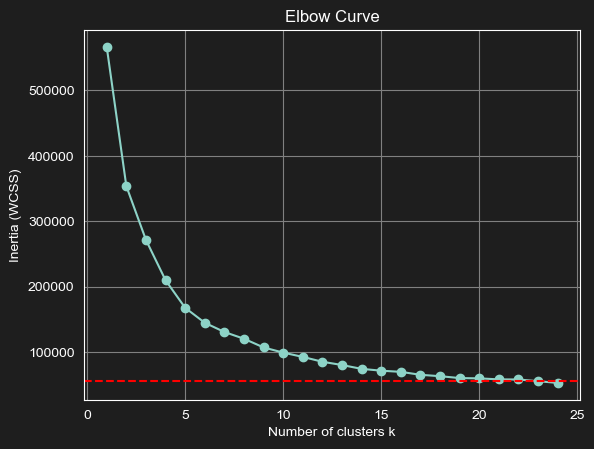

dropping 0 players due to nulls! 


In [96]:
# Calculate Clusters:
filter = 'total_minutes_played  > 1000'
defenders_compare_w_cluster = fit_kmeans(defenders_compare.query(filter),[col for col in defenders_compare.columns if "per_90" in col])

In [90]:
find_player(complete_data,player_name="Micky")

,player_id,player_name,team
40803,152849,Micky van de Ven,VfL Wolfsburg
190597,152849,Micky van de Ven,Tottenham


In [97]:
defenders_compare_w_cluster[defenders_compare_w_cluster.player_name.str.contains("van de")]

,year_e,player_id,player_name,total_games_played,total_minutes_played,average_rating,captain_matches,substitute_appearances,total_shots,shots_on_target,goals_scored,assists,yellow_cards,red_cards,fouls_drawn,fouls_committed,attempted_dribbles,successful_dribbles,dribbled_past,dribble_success_rate,total_passes,key_passes,average_passes_accurate,average_pass_accuracy,total_tackles,blocks,interceptions,duels_contested,duels_won,duels_won_percentage,penalties_won,penalties_committed,penalties_scored,penalties_missed,penalties_saved,team_goals_scored,team_non_penalty_goals,team_goals_conceded,team_non_penalty_goals_conceded,matches_won,total_shots_per_90,shots_on_target_per_90,goals_scored_per_90,assists_per_90,yellow_cards_per_90,red_cards_per_90,fouls_drawn_per_90,fouls_committed_per_90,attempted_dribbles_per_90,successful_dribbles_per_90,dribbled_past_per_90,dribble_success_rate_per_90,total_passes_per_90,key_passes_per_90,average_passes_accurate_per_90,average_pass_accuracy_per_90,total_tackles_per_90,blocks_per_90,interceptions_per_90,duels_contested_per_90,duels_won_per_90,duels_won_percentage_per_90,penalties_won_per_90,penalties_committed_per_90,penalties_scored_per_90,penalties_missed_per_90,penalties_saved_per_90,cluster
248,2025.0,351240,Damian van der Haar,34,1835.0,6.730769,0,12,7.0,3.0,2.0,2.0,1,0,2.0,11.0,11.0,4.0,23.0,0.363636,755.0,14.0,20.571429,75.363664,39.0,5.0,19.0,115.0,54.0,0.469565,0.0,1.0,0,0,0.0,43,43.0,51,51.0,10,0.343324,0.147139,0.098093,0.098093,0.049046,0.0,0.098093,0.539510,0.539510,0.196185,1.128065,32.727273,37.029973,0.686649,28.250681,75.332994,1.912807,0.245232,0.931880,5.640327,2.648501,42.260870,0.000000,0.049046,0.0,0.0,0.0,10
888,2025.0,152849,Micky van de Ven,19,1018.0,6.800000,0,7,5.0,2.0,0.0,2.0,4,0,9.0,10.0,8.0,4.0,6.0,0.500000,793.0,2.0,55.461538,89.250598,10.0,8.0,10.0,87.0,42.0,0.482759,0.0,0.0,0,0,0.0,31,31.0,36,36.0,5,0.442043,0.176817,0.000000,0.176817,0.353635,0.0,0.795678,0.884086,0.707269,0.353635,0.530452,45.000000,70.108055,0.176817,63.742633,89.943234,0.884086,0.707269,0.884086,7.691552,3.713163,43.448276,0.000000,0.000000,0.0,0.0,0.0,9
897,2025.0,19322,Mike van der Hoorn,32,2559.0,7.154839,1,2,19.0,8.0,3.0,2.0,6,0,21.0,23.0,3.0,1.0,9.0,0.333333,1626.0,13.0,43.000000,81.966617,40.0,13.0,38.0,331.0,213.0,0.643505,0.0,1.0,0,0,0.0,59,59.0,41,41.0,18,0.668230,0.281360,0.105510,0.070340,0.211020,0.0,0.738570,0.808910,0.105510,0.035170,0.316530,30.000000,57.186401,0.457210,46.881594,81.849899,1.406800,0.457210,1.336460,11.641266,7.491208,57.915408,0.000000,0.035170,0.0,0.0,0.0,11
1135,2025.0,36922,Sepp van den Berg,32,2588.0,6.977419,0,3,18.0,6.0,0.0,0.0,3,0,5.0,23.0,7.0,4.0,10.0,0.571429,1205.0,6.0,33.322581,85.264396,39.0,38.0,22.0,260.0,142.0,0.546154,1.0,0.0,0,0,0.0,59,59.0,52,52.0,14,0.625966,0.208655,0.000000,0.000000,0.104328,0.0,0.173879,0.799845,0.243431,0.139104,0.347759,51.428571,41.904946,0.208655,35.923493,85.051754,1.356260,1.321484,0.765070,9.041731,4.938176,49.153846,0.034776,0.000000,0.0,0.0,0.0,2


In [99]:
print(defenders_compare_w_cluster[defenders_compare_w_cluster.player_name == 'Micky van de Ven'][['cluster']])
defenders_compare_w_cluster[defenders_compare_w_cluster.cluster == defenders_compare_w_cluster[defenders_compare_w_cluster.player_name == 'Micky van de Ven']['cluster'].values[0]]

     cluster
888        9


,year_e,player_id,player_name,total_games_played,total_minutes_played,average_rating,captain_matches,substitute_appearances,total_shots,shots_on_target,goals_scored,assists,yellow_cards,red_cards,fouls_drawn,fouls_committed,attempted_dribbles,successful_dribbles,dribbled_past,dribble_success_rate,total_passes,key_passes,average_passes_accurate,average_pass_accuracy,total_tackles,blocks,interceptions,duels_contested,duels_won,duels_won_percentage,penalties_won,penalties_committed,penalties_scored,penalties_missed,penalties_saved,team_goals_scored,team_non_penalty_goals,team_goals_conceded,team_non_penalty_goals_conceded,matches_won,total_shots_per_90,shots_on_target_per_90,goals_scored_per_90,assists_per_90,yellow_cards_per_90,red_cards_per_90,fouls_drawn_per_90,fouls_committed_per_90,attempted_dribbles_per_90,successful_dribbles_per_90,dribbled_past_per_90,dribble_success_rate_per_90,total_passes_per_90,key_passes_per_90,average_passes_accurate_per_90,average_pass_accuracy_per_90,total_tackles_per_90,blocks_per_90,interceptions_per_90,duels_contested_per_90,duels_won_per_90,duels_won_percentage_per_90,penalties_won_per_90,penalties_committed_per_90,penalties_scored_per_90,penalties_missed_per_90,penalties_saved_per_90,cluster
20,2025.0,9,Achraf Hakimi,27,2067.0,7.752000,7,3,23.0,13.0,4.0,6.0,4,0,25.0,19.0,47.0,26.0,28.0,0.553191,1907.0,51.0,69.320000,90.625588,48.0,2.0,31.0,201.0,108.0,0.537313,0.0,0.0,0,0,0.0,76,76.0,27,27.0,23,1.001451,0.566038,0.174165,0.261248,0.174165,0.000000,1.088534,0.827286,2.046444,1.132075,1.219158,49.787234,83.033382,2.220610,75.457184,90.879857,2.089985,0.087083,1.349782,8.751814,4.702467,48.358209,0.000000,0.000000,0.000000,0.0,0.0,9
51,2025.0,31009,Alessandro Bastoni,36,2420.0,7.251515,0,5,11.0,2.0,1.0,5.0,6,1,39.0,44.0,12.0,7.0,10.0,0.583333,2031.0,28.0,55.757576,90.193182,46.0,13.0,22.0,223.0,136.0,0.609865,0.0,0.0,0,0,0.0,77,77.0,33,33.0,23,0.409091,0.074380,0.037190,0.185950,0.223140,0.037190,1.450413,1.636364,0.446281,0.260331,0.371901,52.500000,75.533058,1.041322,68.429752,90.009565,1.710744,0.483471,0.818182,8.293388,5.057851,54.887892,0.000000,0.000000,0.000000,0.0,0.0,9
120,2025.0,2285,Antonio Rüdiger,30,2298.0,7.020690,0,4,18.0,4.0,0.0,0.0,3,0,15.0,15.0,5.0,3.0,4.0,0.600000,1839.0,6.0,58.482759,91.293791,20.0,14.0,9.0,119.0,72.0,0.605042,2.0,1.0,0,0,0.0,62,62.0,28,28.0,21,0.704961,0.156658,0.000000,0.000000,0.117493,0.000000,0.587467,0.587467,0.195822,0.117493,0.156658,54.000000,72.023499,0.234987,66.422977,91.847898,0.783290,0.548303,0.352480,4.660574,2.819843,54.453782,0.078329,0.039164,0.000000,0.0,0.0,9
246,2025.0,531,Daley Blind,35,2779.0,7.026471,0,4,6.0,4.0,0.0,2.0,2,0,16.0,19.0,26.0,15.0,17.0,0.576923,2437.0,19.0,64.705882,89.270674,49.0,9.0,31.0,179.0,97.0,0.541899,0.0,0.0,0,0,0.0,40,40.0,57,57.0,9,0.194315,0.129543,0.000000,0.064772,0.064772,0.000000,0.518172,0.615329,0.842030,0.485786,0.550558,51.923077,78.924073,0.615329,71.248651,89.259838,1.586902,0.291472,1.003958,5.797049,3.141418,48.770950,0.000000,0.000000,0.000000,0.0,0.0,9
324,2025.0,30399,Dávid Hancko,33,2880.0,7.278125,15,1,39.0,16.0,3.0,1.0,5,0,21.0,13.0,28.0,12.0,5.0,0.428571,2521.0,20.0,71.156250,89.687000,38.0,20.0,28.0,191.0,116.0,0.607330,0.0,1.0,0,0,0.0,70,70.0,36,36.0,19,1.218750,0.500000,0.093750,0.031250,0.156250,0.000000,0.656250,0.406250,0.875000,0.375000,0.156250,38.571429,78.781250,0.625000,71.156250,89.687000,1.187500,0.625000,0.875000,5.968750,3.625000,54.659686,0.000000,0.031250,0.000000,0.0,0.0,9
357,2025.0,619,Eric García,32,1584.0,6.996552,0,18,11.0,8.0,2.0,3.0,4,0,8.0,20.0,10.0,5.0,9.0,0.500000,1288.0,7.0,41.034483,90.946944,37.0,8.0,16.0,139.0,77.0,0.553957,0.0,0.0,0,0,0.0,86,86.0,33,33.0,24,0.625000,0.454545,0.113636,0.170455,0.227273,0.000000,0.454545,1.136364,0.568182,0.284091,0.511364,45.000000,73.181818,0.397727,67.613636,92.029668,2.102273,0.454545,0.909091,7.897727,4.375000,49.856115,0.000000,0.000000,0.000000,0.0,0.0,9
578,2025.0,972,Jonathan Tah,33,2970.0,7.124242,5,0,16.0,7.0,3.0,0.

In [102]:
defenders_compare_w_cluster[(defenders_compare_w_cluster.player_name.isin(["Giovanni Leoni","Nikola Milenković","Marc Guéhi","Ladislav Krejčí"]))][['player_name'] + [col for col in defenders_compare.columns if "per_90" in col]].T

,432,683,783,960
player_name,Giovanni Leoni,Ladislav Krejčí,Marc Guéhi,Nikola Milenković
total_shots_per_90,0.149626,0.516605,0.264706,0.648649
shots_on_target_per_90,0.074813,0.184502,0.205882,0.216216
goals_scored_per_90,0.074813,0.073801,0.088235,0.135135
assists_per_90,0.0,0.0,0.058824,0.054054
yellow_cards_per_90,0.224439,0.332103,0.264706,0.108108
red_cards_per_90,0.074813,0.0,0.029412,0.0
fouls_drawn_per_90,0.673317,0.627306,0.794118,0.135135
fouls_committed_per_90,0.822943,0.885609,0.705882,0.540541
attempted_dribbles_per_90,0.224439,0.405904,0.411765,0.027027


In [ ]:
# quick knn clustering
from sklearn.cluster import KMeans


# who is ekitike most similar to 

attack_col_set = list(set(['major_position','player_id','player_name'] + config["ATTACK_COLS"] + config["PASSING_COLS"]))
defense_col_set =  list(set(['major_position','player_id','player_name'] + config["DEFENSE_COLS"] + config["PASSING_COLS"]))

# primary position:



striker_stats = complete_data[interest_col_set].fillna(0)[complete_data[interest_col_set].fillna(0).major_position.isin(['F'])].groupby(['player_id','player_name'],as_index = False).agg(n_games = ('player_name','size'),
                                                                          avg_dribble_success = ('dribble_success_rate','mean'),
                                                                          std_dribble_success = ('dribble_success_rate','std'),
                                                                          avg_target_shot_cr = ('target_shot_conversion_perc','mean'),
                                                                          std_target_shot_cr = ('target_shot_conversion_perc','std'),
                                                                          avg_duels_cr = ('duels_won_perc','mean'),
                                                                          std_duels_cr = ('duels_won_perc','std'),
                                                                          avg_pass_accuracy = ('pass_accuracy_perc','mean'),
                                                                          std_pass_accuracy = ('pass_accuracy_perc','std')
                                                                          )


striker_stats = striker_stats[striker_stats.n_games > 40]
striker_stats.shape


In [ ]:
striker_stats.sort_values('avg_dribble_success',ascending=False)

In [ ]:
stats = ['avg_target_shot_cr','avg_dribble_success','avg_duels_cr','avg_pass_accuracy']

for stat in stats:
    striker_stats = fit_optimal_kmeans(striker_stats,stat)

# Clustering

In [ ]:
# Best Goal Scorers:
striker_stats.sort_values(["avg_target_shot_cr","cluster_avg_target_shot_cr"],ascending= [0,0])[["player_name","n_games","avg_target_shot_cr","std_target_shot_cr","cluster_avg_target_shot_cr"]].head(15)

In [ ]:
striker_stats[striker_stats.cluster_avg_target_shot_cr == 9]

In [ ]:
# Best Dribblers:
striker_stats.sort_values(["avg_dribble_success","cluster_avg_dribble_success"],ascending= [0,0])[["player_name","n_games","avg_dribble_success","std_dribble_success","cluster_avg_dribble_success"]].head(20)

In [ ]:
striker_stats[striker_stats.cluster_avg_dribble_success == 20]

In [ ]:
striker_stats.sort_values(["avg_duels_cr","cluster_avg_duels_cr"],ascending= [0,0])[["player_name","n_games","avg_duels_cr","std_duels_cr","cluster_avg_duels_cr"]].head(20)

In [ ]:
striker_stats.sort_values(["avg_pass_accuracy","cluster_avg_pass_accuracy"],ascending= [0,0])[["player_name","n_games","avg_pass_accuracy","std_pass_accuracy","cluster_avg_pass_accuracy"]].head(15)

In [ ]:
striker_stats[striker_stats.cluster_pass == 4]

In [ ]:
filter_query = 'major_position.isin(["M"])'


# Stat to look at:
stat = 'target_shot_conversion_perc'
agg_fun = "mean"
rank_cutoff = 20

# configs 
min_appearance = 40

dribble_dat_g = complete_data.query(filter_query).reset_index().fillna(0).groupby("player_name").agg(n_apps = ("player_name","size"),stat = (stat,agg_fun)).reset_index()
dribble_dat_g = dribble_dat_g[dribble_dat_g.n_apps >= min_appearance]
dribble_dat_g['rank'] = dribble_dat_g["stat"].fillna(0).rank(ascending= False,method = 'dense')
dribble_dat_g.sort_values("rank",inplace = True)

fig, ax = plt.subplots(figsize=(13, 8))

# Plot correctly, no comma here
sns.boxplot(
    data=complete_data.query(filter_query)[complete_data.query(filter_query).player_name.isin(dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'])],
    x="player_name",
    y=stat,
    order=dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'],
    ax=ax,
    
)

# Now this works correctly on `ax`
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(f"Stat: {stat}")
plt.tight_layout()
plt.show()


In [ ]:
fig = plt.subplots(nrows=1, ncols = 1, figsize = (20,10))
fig = sns.heatmap(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']].corr(),cmap = 'coolwarm')
fig.set_xticklabels(fig.get_xticklabels(),rotation = 60)


In [ ]:
sns.pairplot(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']])

In [ ]:
complete_data['win'].value_counts(normalize=True)

In [ ]:
complete_data.head()

In [ ]:
# trial multiclass model:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete_data.query(filter_query)[list(set(config['PASSING_COLS'] + config['ATTACK_COLS'] ))],
                                                    complete_data.query(filter_query)['win'],
                                                    stratify=complete_data.query(filter_query)['win'],
                                                    random_state=33)


In [ ]:
create_submodel("catboost")

In [ ]:
output_path

In [ ]:
model = run_model_with_fs_tune(X_train, X_test, y_train, y_test,dat_dict,'catboost',output_path=folder_manager.output_path)

In [ ]:
dat = NNDataFromPd(X_train.fillna(0), y_train.outcome_num, dat_dict)
train_loader = DataLoader(dat, batch_size = 128,shuffle= True)

In [ ]:
train_loader.dataset.X_numeric_tensor.shape

In [ ]:
# model params
n_features = X_train.shape[1]
n_classes = y_train.iloc[:,0].nunique()
model = MultiClassModel(n_features,n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
epochs = 500

for epoch in range(epochs):
    
    epoch_loss = 0

    for X_numeric_batch, X_categoric_batch, y_batch in train_loader:
        
        pred = model.forward(X_numeric_batch)
        
        loss = criterion(pred,y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

In [ ]:
model.eval()

In [ ]:
X_test['passes_accuracy'] = X_test['passes_accuracy'].astype("float64")

In [ ]:
# test sets

test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

In [ ]:
model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_class = torch.argmax(output, dim = 1)

In [ ]:
# Logistic Model:
X_train, X_test, y_train, y_test = train_test_split(complete_data[complete_data.games_position == 'F'][list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['win']].drop(columns = 'win'),
                                                    complete_data[complete_data.games_position == 'F']['win'],
                                                    stratify=complete_data['win'],
                                                    random_state=33)

In [ ]:
train_dat = NNDataFromPd(X_train,y_train,dat_dict)
train_loader = DataLoader(train_dat,batch_size= 128,shuffle = True)

In [ ]:
n_features = X_train.shape[1]
model = LogisticNNModelComplex(n_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.005)

In [ ]:
epochs = 500
for epoch in range(epochs):
    epoch_loss = 0
    
    for X_numeric, X_categoric, y in train_loader:

        pred = model(X_numeric)

        loss = criterion(pred,y.unsqueeze(1))

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch},  Loss: {loss}")


In [ ]:
pred_proba.squeeze(1)

In [ ]:
from validations import *


test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_proba = torch.softmax(output,dim =1)
        pred_class = torch.argmax(output, dim = 1)


discrete_evaluations(y_test,pred_class,pred_proba.squeeze(1),classification_type="Binary",model_path= folder_manager.output_path)

In [ ]:
test_fixtures = get_team_fixtures("Liverpool",2)

In [ ]:
test_fixtures

In [ ]:
player_stat_url = "https://v3.football.api-sports.io/fixtures/players?fixture={}".format(1035045)
fixture_dat = requests.get(player_stat_url,headers=headers_api_sport)

In [ ]:
pd.json_normalize(pd.json_normalize(fixture_dat.json()['response']))['players'][0]

In [ ]:
fixture_dat_expanded = pd.concat([pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])[['player.id','player.name']],pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])['statistics']).rename(columns = {0:"player_stats"})['player_stats'])],axis = 1)

In [ ]:
fixtures_stat = complete_data.groupby(['fixture_id','team'],as_index=False).agg(n_opponent = ('opponent','count'),total_passes = ('passes_total','sum')).sort_values('fixture_id',ascending= False)

In [ ]:
fixtures_stat

In [ ]:
complete_data[complete_data.fixture_id == 1376437][['team','opponent']]

In [ ]:
teams_dat[teams_dat.team_name.str.contains("Tels")]

In [ ]:
angers = pd.read_parquet(home_dir + "/data/Fixtures/angers_2024.parquet")

In [ ]:
angers['fixture_date'] = pd.to_datetime(angers['fixture_date'])

In [ ]:
angers['fixture_date']